## Download and Format Images 

Decide below which "concepts" to include. These are the classes you want to be able to identify.

In [1]:
# Missing Mollusca & Nemertea

concepts_to_include = [
    'Annelida',
    'Ascidiacea',
    'Asteroidea',
    'Ceriantharia',
    'C
    'Crinoidea',
    'Echinoidea',
    'Gastropoda',
    'Hexacorallia',
    'Holothuroidea',
    'Octocorallia',
    'Ophiuroidea',
    'Porifera',
    'Pycnogonida',
]

Using fathomnet's api we can look and see the number of bounding boxes present in fathomnet for each species

In [2]:
!pip install fathomnet -q

count_command = f'fathomnet-generate -c "{",".join(concepts_to_include)}" --count'
!{count_command}

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip
concept       |  # boxes
--------------|---------
Annelida      |       17
Ascidiacea    |       18
Asteroidea    |     4626
Ceriantharia  |      748
Crinoidea     |     

Some of these are too low to use in our training, so for those less than 100 bounding boxes we will remove them from the included list

In [3]:
too_few_bboxes = ['Annelida','Ascidiacea', 'Echinoidea', 'Pycnogonida']

concepts_to_include = [concept for concept in concepts_to_include if concept not in too_few_bboxes]
concepts_to_include

['Asteroidea',
 'Ceriantharia',
 'Crinoidea',
 'Hexacorallia',
 'Holothuroidea',
 'Octocorallia',
 'Ophiuroidea',
 'Porifera']

Now, we can actually download the images from fathomnet

In [4]:
# Download the images from the fathomnet database
import os

data_directory = os.path.join('datasets', 'sea_data')
img_dir = os.path.join(data_directory, 'images')
label_dir = os.path.join(data_directory, 'labels')

install_command = f'fathomnet-generate -c "{",".join(concepts_to_include)}" --format voc --img-download "{img_dir}" --output "{label_dir}"'
#!{install_command}

Let's take a look at a sample of these images and with their bounding boxes

In [5]:
import xml.etree.ElementTree as ET

def parseXml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bbox_pair = []

    for obj in root.findall('object'):
        name_key = obj.find('name').text
    
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        bbox_pair.append((name_key, (xmin, ymin, xmax, ymax)))
    
    return bbox_pair

In [6]:
!pip install opencv -q

import cv2
from IPython.display import Image, display

def draw_boxes(image, bboxes):    
    for label, (x1, y1, x2, y2) in bboxes:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    display(Image(data=cv2.imencode('.jpg', image_rgb)[1].tobytes()))

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


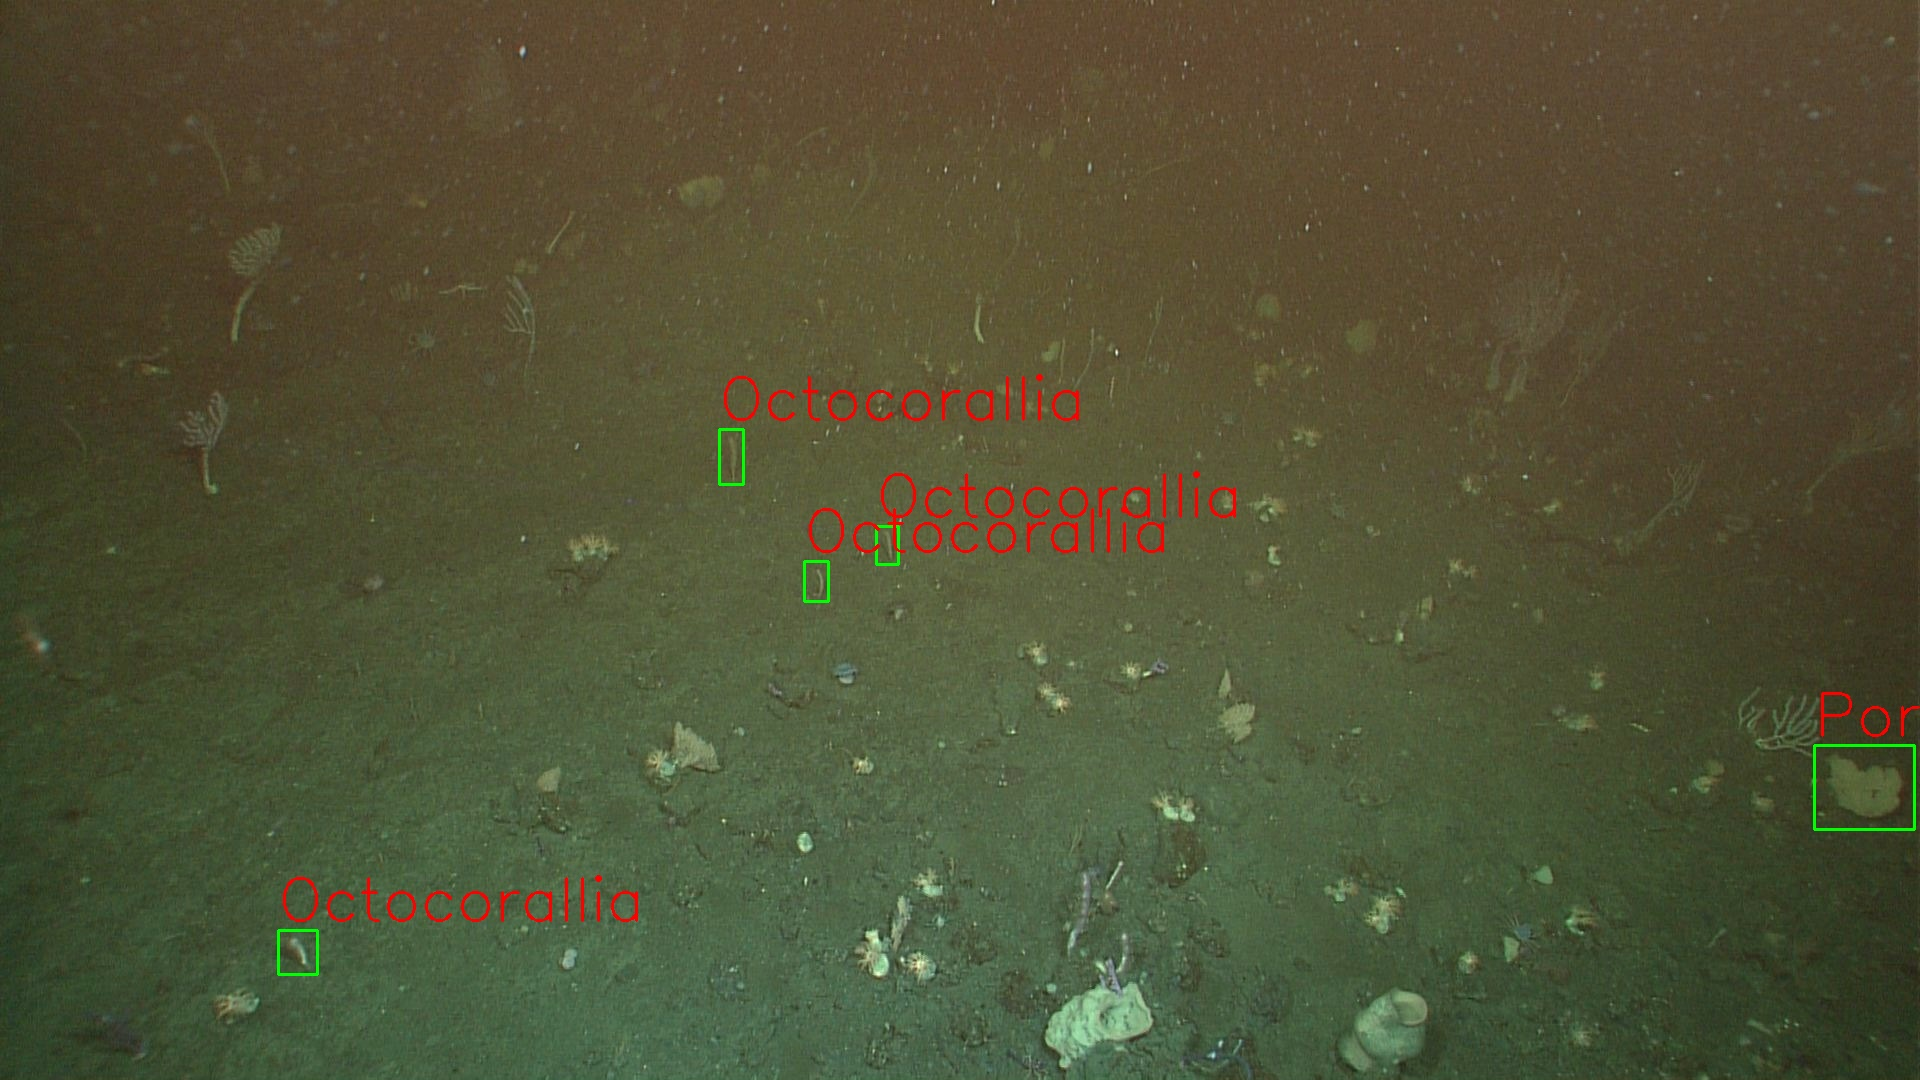

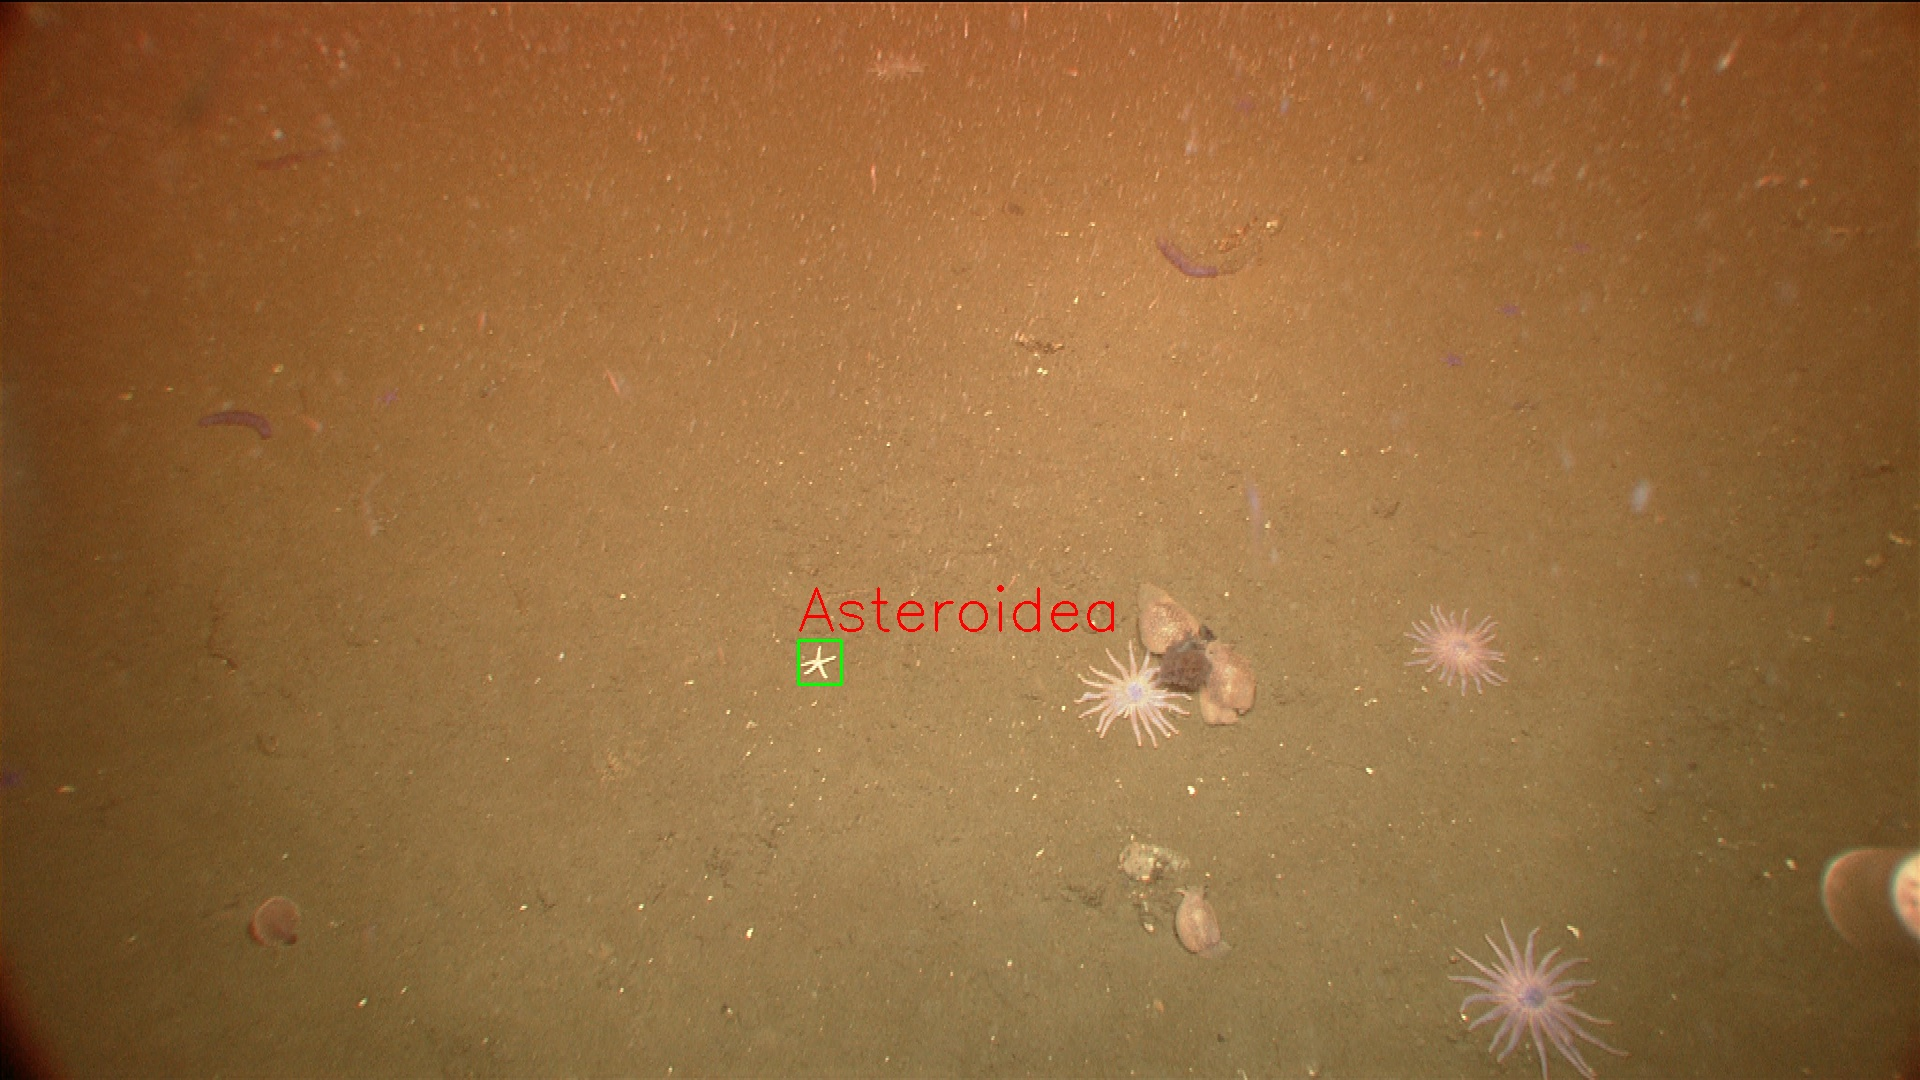

In [7]:
!pip install numpy -q

import numpy as np

number_to_choose = 2
random_seed = 80
np.random.seed(random_seed)

image_dir = os.path.join(data_directory, 'images')
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]


random_images = np.random.choice(image_files, number_to_choose, replace=False)

for name in random_images:
    uid, _ = os.path.splitext(name)

    image_path = os.path.join(image_dir, name)
    image = cv2.imread(image_path)
    bboxes = parseXml(os.path.join(data_directory, 'labels', f"{uid}.xml"))
    
    draw_boxes(image, bboxes)

## Break into train-val-test split

For this experiment we are going to use a train-val-test split of 70%-20%-10%

Since images are encoded using uuid4 we know that there is no order to the downloaded images this means that we can just move the first 70% of each concept into a training directory and so on.
We want to do this by concept so that we ensure that each concept is well represented in our training set.

### Split into concepts

In [8]:
label_directory = os.path.join(data_directory, 'labels')

concept_names = {}
for filename in os.listdir(label_directory):
    if not filename.endswith('.xml'): continue
        
    xml_file_path = os.path.join(label_directory, filename)
    root_name, _ = os.path.splitext(filename)

    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    for obj in root.findall('.//object'):
        name = obj.find('name').text
        if name not in concept_names:
            concept_names[name] = set()
        
        concept_names[name].add(root_name)
            
for concept, names in concept_names.items():
    print(f'Concept: {concept} ::: {len(names)}')


Concept: Porifera ::: 2725
Concept: Holothuroidea ::: 821
Concept: Asteroidea ::: 2667
Concept: Hexacorallia ::: 82
Concept: Ophiuroidea ::: 2687
Concept: Crinoidea ::: 1229
Concept: Ceriantharia ::: 544
Concept: Octocorallia ::: 135


### Move Images for training

In [9]:
!pip install pyyaml
import yaml

train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

def createYamlFile(yaml_name='data'):
    data = {
        "path": 'sea_data',
        "train": [os.path.join('images', train_dir)],
        "val": [os.path.join('images', val_dir)],
        "test": [os.path.join('images', test_dir)],
        "names": {str(idx): class_name for idx, class_name in enumerate(concepts_to_include)}
    }

    with open(os.path.join(data_directory, f"{yaml_name}.yaml"), "w") as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)

createYamlFile()

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
import shutil

def copyImageToLocation(uid, new_id, dest_dir=train_dir):
    curr_location = os.path.join(data_directory, 'images')
    src_file = os.path.join(curr_location, f"{uid}.png")

    file_exists = os.path.isfile(os.path.join(curr_location, f"{uid}.png"))
    if not file_exists: return

    os.makedirs(os.path.join(curr_location, dest_dir), exist_ok=True)
    dest_file = os.path.join(curr_location, dest_dir, f"{new_id}.png")

    shutil.copy(src_file, dest_file)

In [11]:
import xml.etree.ElementTree as ET
import cv2

def createTxtFile(uid, new_id, dest_dir=train_dir):
    curr_location = os.path.join(data_directory, 'labels')

    source_path = os.path.join(curr_location, f'{uid}.xml')
    
    tree = ET.parse(source_path)
    root = tree.getroot()

    file_destination = os.path.join(curr_location, dest_dir)
    os.makedirs(file_destination, exist_ok=True)

    image = cv2.imread(os.path.join(image_dir, dest_dir, f"{new_id}.png"))
    try:
        img_height, img_width, _ = image.shape
    except:
        os.remove(os.path.join(image_dir, dest_dir, f"{new_id}.png"))
        os.remove(os.path.join(image_dir, f"{uid}.png"))
        os.remove(os.path.join(curr_location, f"{uid}.xml"))
        return

    destination_path = os.path.join(file_destination, f'{new_id}.xml')
    shutil.copy(source_path, destination_path)

    with open(os.path.join(file_destination, f'{new_id}.txt'), 'w') as txt_file:
        for obj in root.findall('.//object'):
            name_key = concepts_to_include.index(obj.find('name').text)
    
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            xcenter_norm = ((xmin + xmax) / 2) / img_width
            ycenter_norm = ((ymin + ymax) / 2) / img_height
            width_norm = (xmax - xmin) / img_width
            height_norm = (ymax - ymin) / img_height
            
    
            line = f"{name_key} {xcenter_norm:6f} {ycenter_norm:6f} {width_norm:6f} {height_norm:6f}"
            txt_file.write(line + '\n')

In [12]:
from ipywidgets import IntProgress

img_index = 0
max_images = 9182

progress = IntProgress(min=0, max=max_images)
display(progress)

def createNewFiles(files, target_dir=train_dir):
    global img_index
    for file in files:
        img_index += 1
        progress.value = img_index
        copyImageToLocation(file, "{:012d}".format(img_index), target_dir)
        createTxtFile(file, "{:012d}".format(img_index), target_dir)

IntProgress(value=0, max=9182)

In [13]:
!pip install scikit-learn -q
from sklearn.model_selection import train_test_split

train_size = 0.7
val_size = 0.2
test_size = 0.1

for _, file_list in concept_names.items():
    train_files, test_and_val_files = train_test_split(list(file_list), test_size=(val_size+test_size), random_state=random_seed)
    val_files, test_files = train_test_split(test_and_val_files, test_size=(test_size / (test_size + val_size)), random_state=random_seed)

    createNewFiles(train_files, train_dir)
    createNewFiles(val_files, val_dir)
    createNewFiles(test_files, test_dir)


DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


### Image Samples

In [14]:
def get_corners(mid_norm, dist_norm, dist_abs):
    top_corner_abs = int((mid_norm - dist_norm / 2) * dist_abs)
    bot_corner_abs = int((mid_norm + dist_norm / 2) * dist_abs)
    return top_corner_abs, bot_corner_abs

def parse_txt(text_path, image_size):
    h, w, _ = image_size    
    bbox_pair = []
    
    with open(text_path, 'r') as file:
        for line in file:
            parts = line.strip().split()

            label = concepts_to_include[int(parts[0])]
            x_mid, y_mid, w_norm, h_norm = map(float, parts[1:])
                    
            x0, x1 = get_corners(x_mid, w_norm, w)
            y0, y1 = get_corners(y_mid, h_norm, h)
                
            bbox_pair.append((label, (x0, y0, x1, y1)))

    return bbox_pair

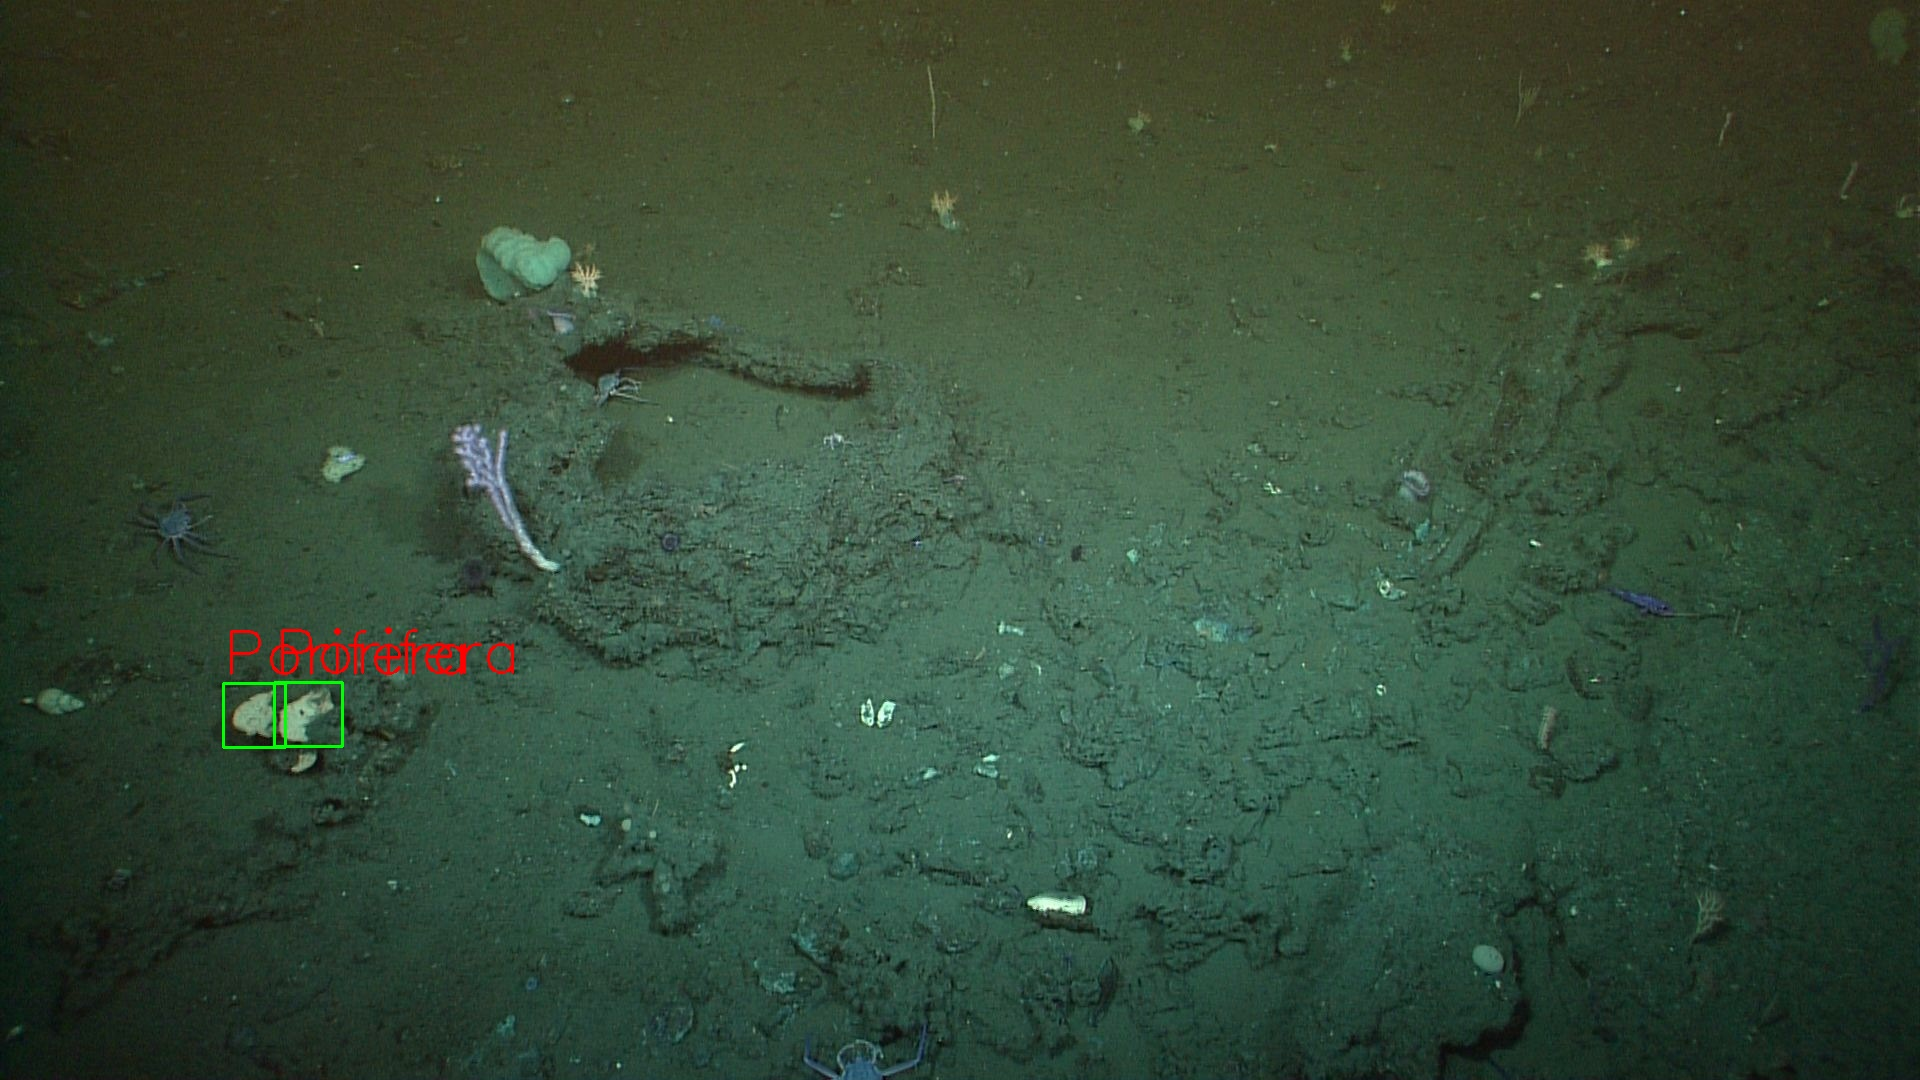

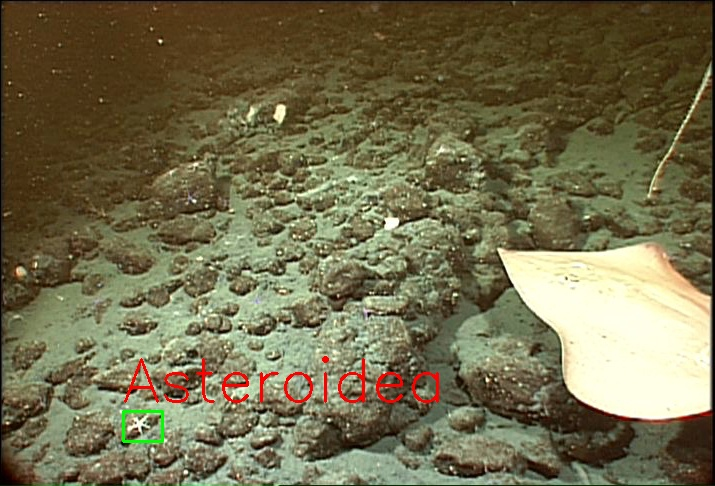

In [15]:
## Sample images for training here
import os
import numpy as np

number_to_choose = 2

image_dir = os.path.join(data_directory, 'images', train_dir)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

random_images = np.random.choice(image_files, number_to_choose, replace=False)

for name in random_images:
    uid, png = os.path.splitext(name)

    image_path = os.path.join(image_dir, name)
    image = cv2.imread(image_path)
    bboxes = parse_txt(os.path.join(data_directory, 'labels', train_dir, f"{uid}.txt"), image.shape)
    
    draw_boxes(image, bboxes)

## Train a YOLOv8 Model

In [16]:
!pip install ultralytics -q

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
psychopy 2020.1.3 requires arabic_reshaper, which is not installed.
psychopy 2020.1.3 requires astunparse, which is n

In [17]:
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8n.yaml').load('yolov8n.pt')

# Train the model
# results = model.train(data=f"{data_directory}/data.yaml", epochs=1)

# Pretrained
model = YOLO('/home/kyle/Documents/ml_projects/ultralytics/runs/detect/train/weights/best.pt')


0: 512x736 3 Asteroideas, 2 Ophiuroideas, 2.1ms
Speed: 2.8ms preprocess, 2.1ms inference, 3.9ms postprocess per image at shape (1, 3, 512, 736)
Results saved to /home/kyle/Documents/ml_projects/ultralytics/runs/detect/predict7


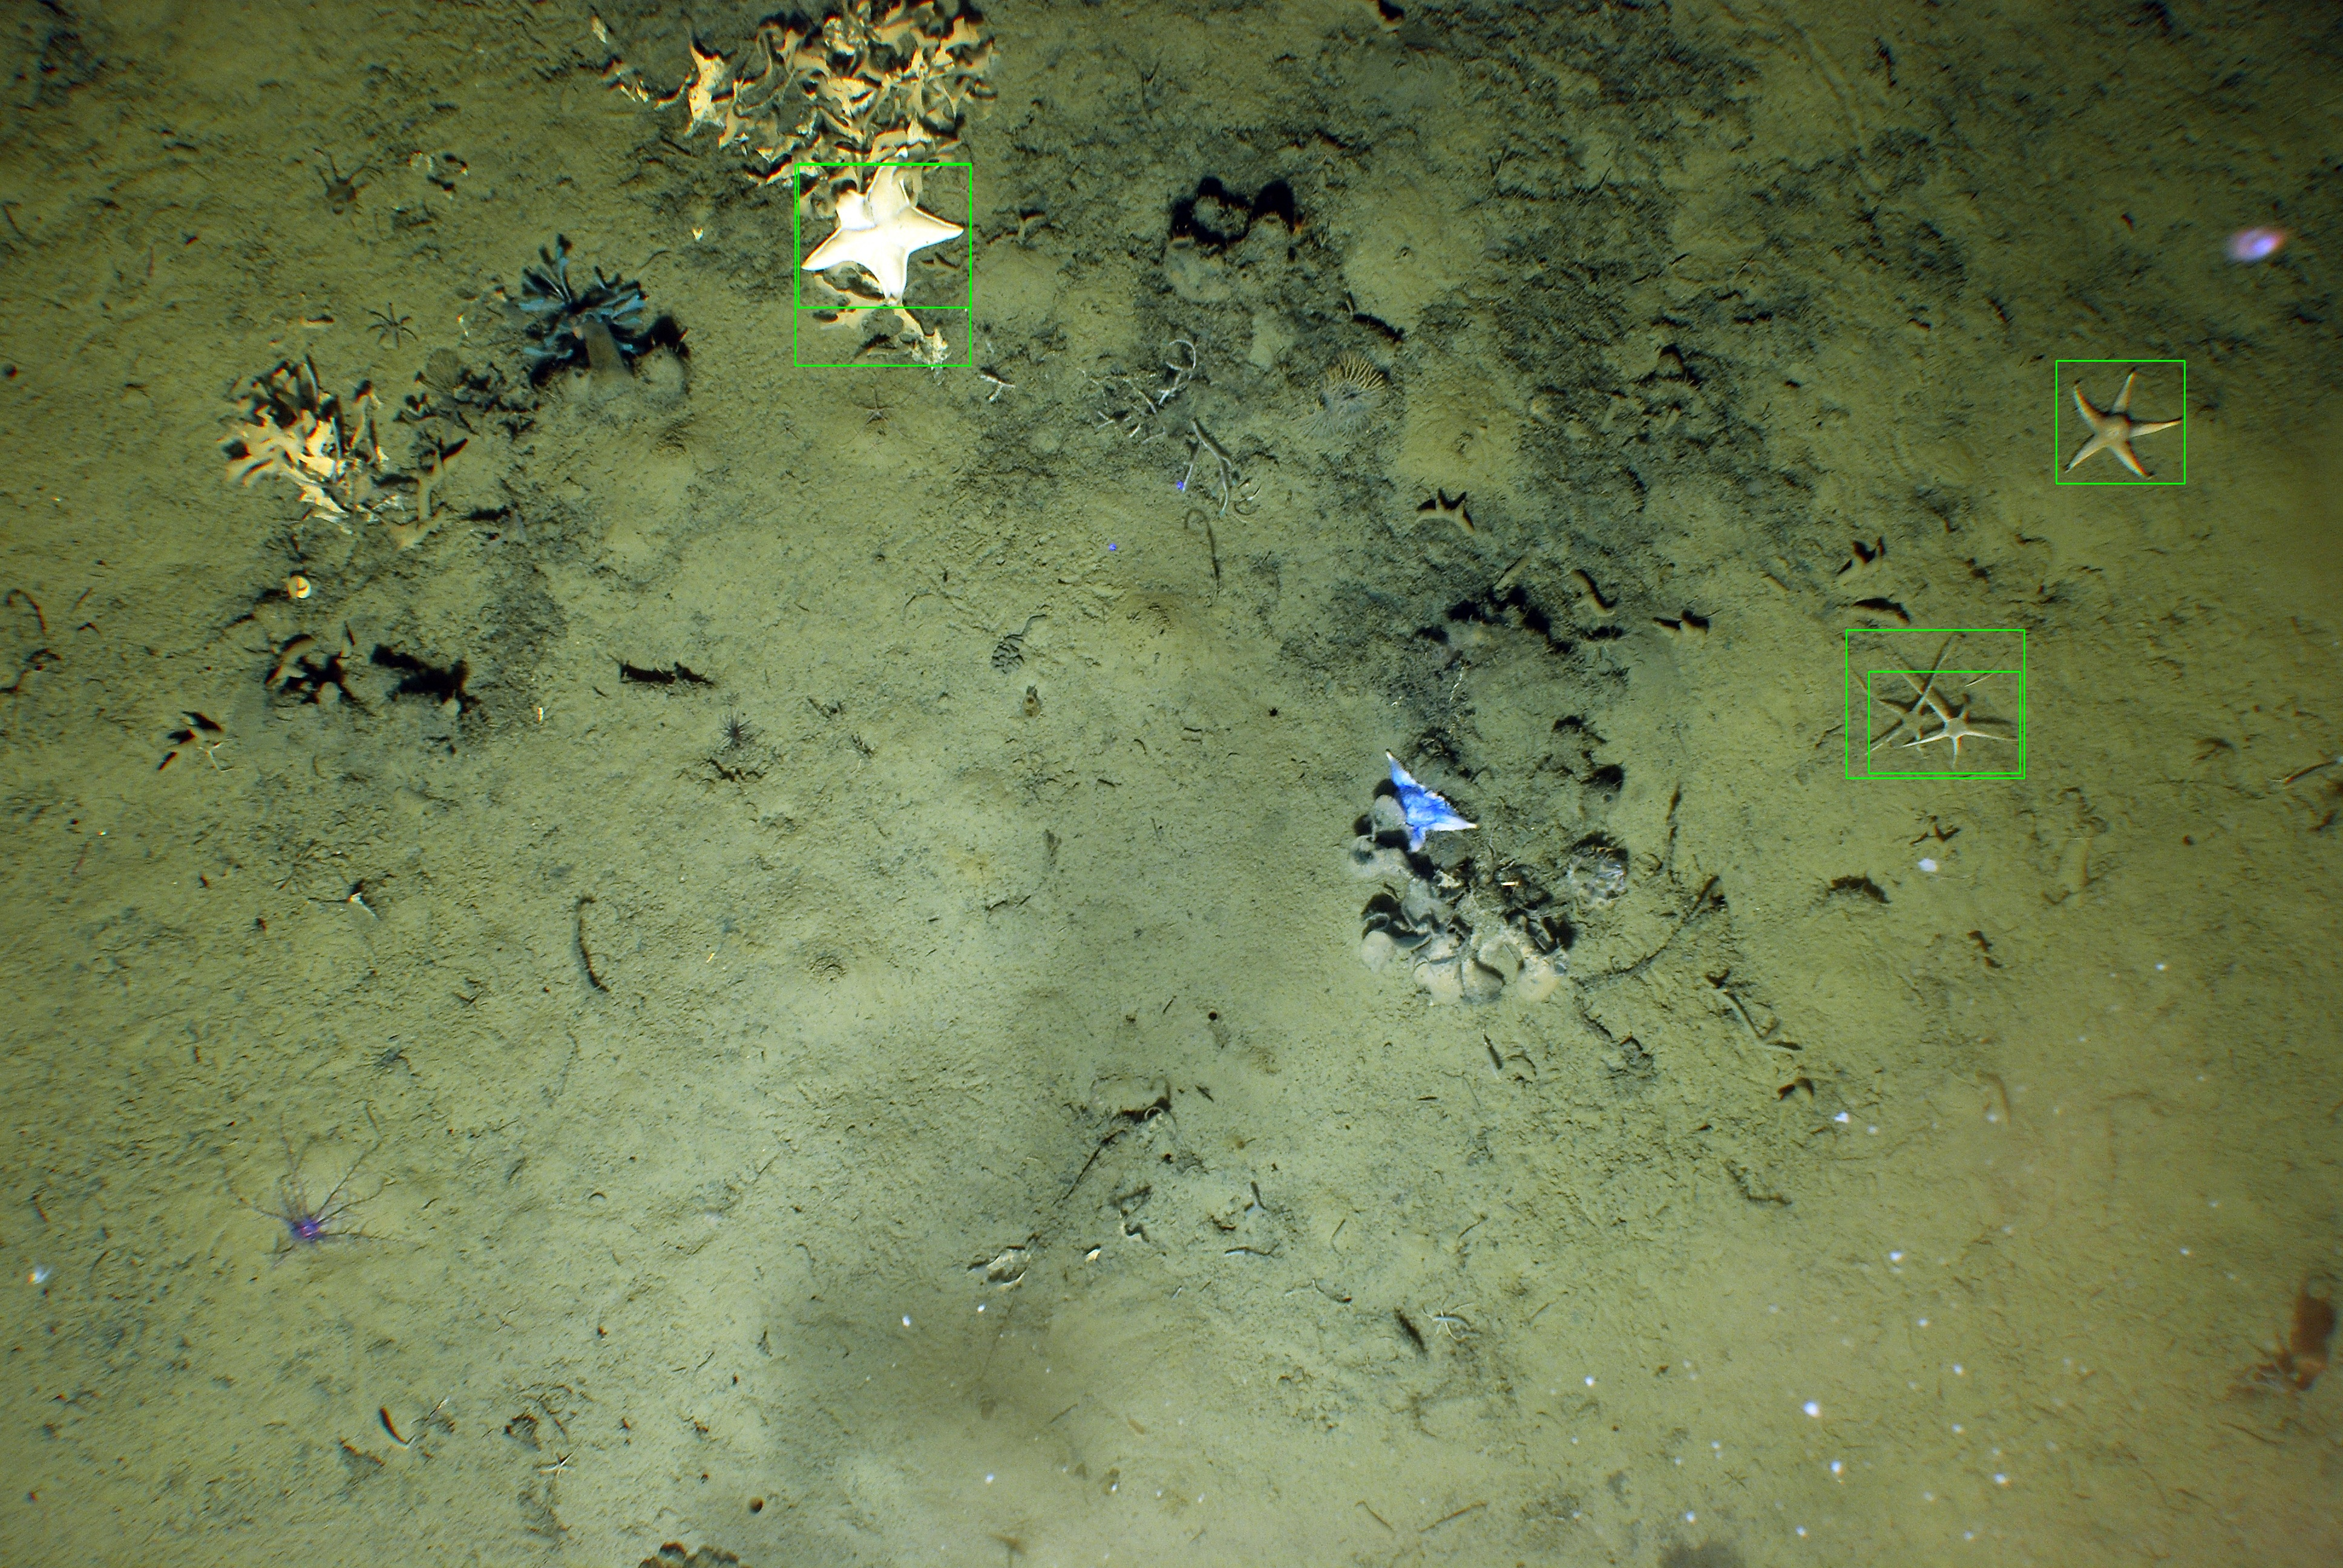

In [18]:
import cv2
from ultralytics.engine.results import Boxes
from IPython.display import display, Image

image = cv2.imread('DSC_0272.jpg')
prediction = model(image, imgsz=[512, 736], conf=0.1, save=True)

for bbox in prediction[0].boxes:
    x1, y1, x2, y2 = bbox.xyxy.cpu()[0].numpy()
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

# Convert the image to RGB format for displaying in the notebook
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes in the notebook
display(Image(data=cv2.imencode('.jpg', image_rgb)[1].tobytes()))

# Train an RCNN model

In [19]:
!pip install torch torchvision pillow -q

import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch_home = os.path.join('torch', 'torchvision_models')
os.environ['TORCH_HOME'] = torch_home
os.makedirs(torch_home, exist_ok=True)

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [20]:
model = model.to(device)

In [22]:
# Placeholder for training visualizations
class TrainingRun:
    def nothing():
        return

In [41]:
import torchvision

model = torchvision.models.resnet50(pretrained=True)
# Replace the final layer with a classifier for 102 classes for the Flowers 102 dataset.
model.fc = nn.Linear(in_features=2048, out_features=len(concepts_to_include), bias=True)
new_layers = [model.fc]

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [54]:


# Extract the original classifier (classification layer)

# Define your custom classification layer
new_classifier = FastRCNNPredictor(
 original_classifier.cls_score.in_features, len(concepts_to_include)
)

# Replace the classification layer with your custom layer

model.roi_heads.box_predictor = new_classifier

model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [27]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

class BenthicResNetClassifier(nn.Module):
    # https://www.kdnuggets.com/2023/06/practical-guide-transfer-learning-pytorch.html
    def __init__(self, load_pretrained=True):
        super().__init__()
        self.new_layers = []

        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
        
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features        
        new_classifier = FastRCNNPredictor(
            in_features, len(concepts_to_include)
        )

        self.new_layer[new_classifier]
        self.model.roi_heads.box_predictor = new_classifier


        # Dummy Param to be able to check the device on which this model is.
        # From https://stackoverflow.com/questions/58926054/how-to-get-the-device-type-of-a-pytorch-module-conveniently
        self.dummy_param = nn.Parameter(torch.empty(0))
        
        # Initialize metrics buffer. element 0 is loss, and element 1 is accuracy.
        self.register_buffer("train_metrics", torch.tensor([float("inf"), 0.0]))
        self.register_buffer("val_metrics", torch.tensor([float("inf"), 0.0]))
        

    def forward(self, x):
        return self.model(x)
    
    def update_metrics(self, run_type, loss, accuracy):
        metrics = self.train_metrics if run_type == "train" else self.val_metrics
        if loss is not None:
            metrics[0] = loss
        if accuracy is not None:
            metrics[1] = accuracy

    def get_metrics(self, run_type):
        metrics = self.train_metrics if run_type == "train" else self.val_metrics
        return dict(zip(["loss", "accuracy"], metrics.tolist()))

    def fine_tune(self, tuning_type):
        # The requires_grad parameter controls whether this parameter is
        # trainable during model training.
        m = self.model
        for p in m.parameters():
            p.requires_grad = False

        if tuning_type == 'feature_extract':
            for l in self.new_layers:
                for p in l.parameters():
                    p.requires_grad = True
                    
        else:
            for p in m.parameters():
                p.requires_grad = True

    def train_one_epoch(self, data_loader, optimizer, epoch=1):
        """Train this model for a single epoch. Return the loss computed
        during this epoch.
        """
        device = self.dummy_param.device
        criterion = nn.CrossEntropyLoss()
        running_loss = 0.0
        num_batches = 0

        for inputs, targets in data_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = self(inputs)
            loss = criterion(outputs, targets)

            running_loss, num_batches = running_loss + loss.item(), num_batches + 1
            loss.backward()
            optimizer.step()

        print(f"[{epoch}] Train Loss: {running_loss / num_batches:0.5f}")
        return running_loss / num_batches

    def evaluate(self, data_loader, metric, epoch, run_type):
        """Evaluate the model on the specified dataset (provided using the DataLoader
        instance). Return the loss and accuracy.
        """
        device = self.dummy_param.device
        criterion = nn.CrossEntropyLoss()
        running_loss = 0.0
        running_accuracy = 0.0
        num_batches = 0
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = self(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            num_batches += 1
            running_accuracy += metric(outputs, targets).item()

        print(f"[{epoch}] {run_type} Loss: {running_loss / num_batches:.5f}, Accuracy: {running_accuracy / num_batches:.5f}")
        return running_loss / num_batches, running_accuracy / num_batches
    
    def train_multiple_epochs_and_save_best_checkpoint(
        self,
        train_loader,
        val_loader,
        accuracy,
        optimizer,
        scheduler,
        epochs,
        filename,
        training_run,
    ):
        """Train this model for multiple epochs. The caller is expected to have frozen
        the layers that should not be trained. We run training for "epochs" epochs.
        The model with the best val accuracy is saved after every epoch.
        
        After every epoch, we also save the train/val loss and accuracy.
        """
        best_val_accuracy = self.get_metrics("val")['accuracy']
        for epoch in range(1, epochs + 1):
            self.train()
            self.train_one_epoch(train_loader, optimizer, epoch)

            # Evaluate accuracy on the train dataset.
            self.eval()
            with torch.inference_mode():
                train_loss, train_acc = self.evaluate(train_loader, accuracy, epoch, "Train")
                training_run.train_loss.append(train_loss)
                training_run.train_accuracy.append(train_acc)
            # end with

            # Evaluate accuracy on the val dataset.
            self.eval()
            with torch.inference_mode():
                val_loss, val_acc = self.evaluate(val_loader, accuracy, epoch, "Val")
                training_run.val_loss.append(val_loss)
                training_run.val_accuracy.append(val_acc)
                if val_acc > best_val_accuracy:
                    # Save this checkpoint.
                    print(f"Current valdation accuracy {val_acc*100.0:.2f} is better than previous best of {best_val_accuracy*100.0:.2f}. Saving checkpoint.")
                    self.update_metrics("train", train_loss, train_acc)
                    self.update_metrics("val", val_loss, val_acc)
                    torch.save(self.state_dict(), filename)
                    best_val_accuracy = val_acc
            # end with
            
            scheduler.step()
        # end for (epoch)
    # end def

    def get_optimizer_params(self):
        """This method is used only during model fine-tuning when we need to
        set a linear or expotentially decaying learning rate (LR) for the
        layers in the model. We exponentially decay the learning rate as we
        move away from the last output layer.
        """
        options = []

        layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
        lr = 0.0001
        for layer_name in reversed(layers):
            options.append({
                "params": getattr(self.model, layer_name).parameters(),
                'lr': lr,
            })
            lr = lr / 3.0

        return options


# Sanity check to see if we can run a single forward pass with this model
# when it is provided an input with the expected shape.
fc_test = BenthicResNetClassifier(load_pretrained=False)
x = torch.randn(4, 3, 224, 224)
y = fc_test(x)
print(x.shape, y.shape)
print(fc_test.get_optimizer_params())

/home/kyle/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kyle/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to torch/torchvision_models/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 92.9MB/s]


AttributeError: 'FasterRCNN' object has no attribute 'fc'

In [20]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import RPNHead

num_classes = len(concepts_to_include)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [34]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import xml.etree.ElementTree as ET


class CustomVOCDataset(Dataset):
    def __init__(self):
        self.image_dir = os.path.join(img_dir, train_dir)
        self.label_dir = os.path.join(label_dir, train_dir)

        self.image_files = [filename for filename in os.listdir(self.image_dir) if filename.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = cv2.imread(img_name)[:,:,:3]
        image = np.transpose(image, (2, 0, 1))
        
        annotation_file = os.path.join(self.label_dir, os.path.splitext(self.image_files[idx])[0] + '.xml')

        tree = ET.parse(annotation_file)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.iter("object"):
            label = obj.find("name").text
            labels.append(label)
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)

            if xmin > xmax:
                t_min = xmax
                xmax = xmin
                xmin = t_min
            if ymin > ymax:
                t_min = ymax
                ymax = ymin
                ymin = t_min

            
            boxes.append([xmin, ymin, xmax, ymax])


        target = {}
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.tensor([int(concepts_to_include.index(label)) for label in labels], dtype=torch.int64)

        return torch.from_numpy(image / 255.0), target

In [35]:
from torch.utils.data import DataLoader

dataset = CustomVOCDataset()
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)

model.train()

num_epochs = 5
for epoch in range(num_epochs):    
    epoch_progress = IntProgress(min=0, max=len(data_loader))
    display(epoch_progress)

    for images, targets in data_loader:   
        epoch_progress.value += 1

        images = list(image.to(device=device, dtype=torch.float) for image in images)
        targets = [{k: v[0].to(device) for k, v in targets.items()}]
        
        loss_dict = model(images, targets)
        sum_loss = sum(loss for loss in loss_dict.values())
    
        sum_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

IntProgress(value=0, max=7618)

In [ ]:
model.eval()

image = cv2.imread('DSC_0272.jpg')[:,:,:3]
image = np.transpose(image, (2, 0, 1))

input_image = torch.from_numpy(image / 255.0).to(dtype=torch.float32)
input_image = input_image.unsqueeze_(0)

with torch.no_grad():
    model.eval()
    output = model(input_image)

In [ ]:
output